In [1]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt

sys.path.append(r"C:\Users\haoyuan\Documents\GitHub\CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, groutine, crystal, lightpath

# Get the Crystal Geometries

In [86]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Pulse
# ----------------------------------------------------------------------------------------------------------
energy_center = 10.
pre_length = 1e6

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[0., 1., 0.],
                              sigma_x=708.2581446128465,
                              sigma_y=708.2581446128465,
                              sigma_z=1.,
                              x0=np.array([0., 0., -pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Split
# ----------------------------------------------------------------------------------------------------------
dtheta = np.arctan(1.5 * 1e-3 / 5.)  # This is the deviation angle.
half_period = util.get_grating_period(dtheta=dtheta,
                                      klen_in=my_pulse.klen0) / 2

grating_list = [crystal.RectangleGrating(), crystal.RectangleGrating()]
grating_list[0].set_a(half_period)
grating_list[0].set_b(half_period)
grating_list[1].set_a(half_period)
grating_list[1].set_b(half_period)

# ----------------------------------------------------------------------------------------------------------
#                       Step 3: Delay Lines
# ----------------------------------------------------------------------------------------------------------
# Some meta data for the delay line.
h_length = 2. * np.pi / (1.9201 * 1e-4)

# Some crystal properties
chi0 = complex(-0.97631E-05, 0.14871E-06)
chih_sigma = complex(0.59310E-05, -0.14320E-06)
chihbar_sigma = complex(0.59310E-05, -0.14320E-06)
chih_pi = complex(0.46945E-05, -0.11201E-06)
chihbar_pi = complex(0.46945E-05, -0.11201E-06)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal before the grating
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
bragg = np.radians(18.836) + 13e-6

# Get crystal angles
eta_b0 = np.zeros(6, dtype=np.float64)
theta_b0 = np.array([np.pi / 2. + bragg,
                     3 * np.pi / 2. + bragg,
                     3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg])

rho_b0 = theta_b0 + np.pi
rho_b0[1] += np.deg2rad(5)
rho_b0[2] -= np.deg2rad(5)

tau_b0 = np.array([0., 0, 0, 0.])

# Initialize the crystals
crystal_list_0 = lclsutil.get_crystal_list(num=4,
                                           hlen=np.array([h_length, ] * 4),
                                           theta=theta_b0,
                                           eta=eta_b0,
                                           rho=rho_b0,
                                           tau=tau_b0,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_1 = dtheta

# Bragg angle
bragg = np.radians(18.836) + 13e-6
miscut = np.deg2rad(10.)

# Get crystal angles
eta_b1 = np.zeros(6, dtype=np.float64)
theta_b1 = np.array([np.pi / 2. + bragg,
                     3 * np.pi / 2. + bragg,
                     3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg])
rho_b1 = theta_b1 + np.pi
rho_b1[1] -= np.deg2rad(5)
rho_b1[2] -= np.deg2rad(5)
tau_b1 = np.array([0., 0, 0, 0.])

# Add the effect of the global rotation due to the grating momentum transfer
theta_b1 += angle_offset_1
rho_b1 += angle_offset_1

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list(num=4,
                                           hlen=np.array([h_length, ] * 4),
                                           theta=theta_b1,
                                           eta=eta_b1,
                                           rho=rho_b1,
                                           tau=tau_b1,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  2
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_2 = - dtheta
bragg = np.radians(18.836) + 13e-6

# Get crystal angles
eta_b2 = np.zeros(4, dtype=np.float64)
theta_b2 = np.array([3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg,
                     np.pi / 2. + bragg,
                     3 * np.pi / 2. + bragg])
rho_b2 = theta_b2 + np.pi
rho_b2[1] += np.deg2rad(5)
rho_b2[3] -= np.deg2rad(5)

tau_b2 = np.zeros(4, dtype=np.float64)

# Add the effect of the global rotation due to the grating momentum transfer
theta_b2 += angle_offset_2
rho_b2 += angle_offset_2

# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list(num=4,
                                           hlen=np.array([h_length, ] * 4),
                                           theta=theta_b2,
                                           eta=eta_b2,
                                           rho=rho_b2,
                                           tau=tau_b2,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ------------------------------------------------------
#   Define the positions
# ------------------------------------------------------
path_list_0 = [1e5, 1e5, 1e5, 5e5]
path_list_1 = [5e6 - 10e4, 1e5, 5e5, 1.05e5, 6e6, 1e6]
path_list_2 = [5e6       , 1e5, 1e5, 1.05e5, 6e6, 1e6]
delay_time = 0

In [87]:
for x in crystal_list_0:
    print(x.normal)

[ 0.         -0.94644239  0.32287273]
[ 0.          0.91470068 -0.40413199]
[0.         0.91470068 0.40413199]
[ 0.         -0.94644239 -0.32287273]


# Arrange the crystals

In [88]:
# Get the positions for the shearing fix branch
(intersect_branch_0,
kout_branch_0) = lightpath.get_point_with_definite_path(kin_vec=my_pulse.k0,
                                                        path_sections=path_list_0,
                                                        crystal_list=crystal_list_0,
                                                        init_point=np.zeros(3))

In [89]:
print(kout_branch_0)

[[ 0.00000000e+00  3.09719880e+04  4.01114131e+04]
 [ 0.00000000e+00  3.06764844e-01  5.06773076e+04]
 [ 0.00000000e+00 -3.09728086e+04  4.01107795e+04]
 [ 0.00000000e+00  1.03671435e+00  5.06773076e+04]]


In [90]:
intersect_branch_0

array([[ 0.00000000e+00,  6.11160882e+04,  7.91506397e+04],
       [ 0.00000000e+00,  6.11166935e+04,  1.79150640e+05],
       [ 0.00000000e+00, -1.01385559e+00,  2.58300029e+05],
       [ 0.00000000e+00,  9.21472993e+00,  7.58300029e+05]])

In [69]:
# Get the positions for the shearing fix branch
(intersect_branch_0,
kout_branch_0) = lightpath.get_point_with_definite_path(kin_vec=my_pulse.k0,
                                                        path_sections=path_list_0,
                                                        crystal_list=crystal_list_0,
                                                        init_point=np.zeros(3))

# Adjust the path sections
(path_list_1,
 kout_brunch_1,
 intersect_branch_1,
 path_list_2,
 kout_brunch_1,
 intersect_branch_2) = lightpath.adjust_path_length(delay_time=delay_time,
                                               fix_branch_path=path_list_2,
                                               fix_branch_crystal=crystal_list_2,
                                               var_branch_path=path_list_1,
                                               var_branch_crystal=crystal_list_1,
                                               grating_pair=grating_list,
                                               kin=kout_branch_0[-1])

#"""
# Shift the intersection points due to the insertion of the new unit
shift = intersect_branch_0[-1] 
intersect_branch_1 += shift[np.newaxis, :]
intersect_branch_2 += shift[np.newaxis, :]


# Initialize the crystals
position_tmp = np.zeros((4,3))
position_tmp[1:] = intersect_branch_0[:-1]

crystal_list_0 = lclsutil.update_crystal_list(crystal_list_0,
                                              surface_points=np.copy(position_tmp))
crystal_list_1 = lclsutil.update_crystal_list(crystal_list_1,
                                              surface_points=np.copy(intersect_branch_1[1:-2]))
crystal_list_2 = lclsutil.update_crystal_list(crystal_list_2,
                                              surface_points=np.copy(intersect_branch_2[1:-2]))
grating_list[0].set_surface_point(np.copy(intersect_branch_2[0]))
grating_list[1].set_surface_point(np.copy(intersect_branch_2[-2]))


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the observation point
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
observation = np.copy(intersect_branch_2[-1]) 
total_path = pre_length + np.sum(path_list_2) + np.sum(path_list_0)

print("The total propagation length is {:.2f}m.".format(total_path / 1e6))
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Change frame
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(my_pulse,
 observation,
 [crystal_list_0,
  crystal_list_1, 
  crystal_list_2,
  grating_list]
) = lclsutil.get_output_frame(displacement=-np.copy(intersect_branch_2[-1]),
                              observe=observation,
                              pulse=my_pulse,
                              crystal_lists = [crystal_list_0,
                                               crystal_list_1, 
                                               crystal_list_2,
                                               grating_list])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
number_x = 2
number_y = 250
number_z = 10 ** 5
kx_grid, ky_grid, kz_grid, axis_info = util.get_k_mesh_3d(number_x=number_x,
                                                              number_y=number_y,
                                                              number_z=number_z,
                                                              delta_e_x=1e-50,
                                                              delta_e_y=1e-4,
                                                              delta_e_z=1e-3 / util.c)
kz_grid += my_pulse.klen0

# Apply fft shift
kx_grid = np.zeros(1, np.float64)
number_x = 1
ky_grid = np.ascontiguousarray(np.fft.fftshift(ky_grid))
kz_grid = np.ascontiguousarray(np.fft.fftshift(kz_grid))


The total propagation length is 12.99m.


In [70]:
kout_brunch_2

array([[ 0.00000000e+00,  1.03671435e+00,  5.06773076e+04],
       [ 0.00000000e+00, -1.41664779e+01,  5.06773076e+04],
       [ 0.00000000e+00, -3.09848416e+04,  4.01014874e+04],
       [ 0.00000000e+00, -1.29326545e+01,  5.06773079e+04],
       [ 0.00000000e+00,  3.09586476e+04,  4.01217129e+04],
       [ 0.00000000e+00, -1.35525635e+01,  5.06773077e+04],
       [ 0.00000000e+00,  1.65062878e+00,  5.06773077e+04]])

In [71]:
intersect_branch_2

array([[ 0.00000000e+00, -1.10929846e+00,  7.58300909e+05],
       [ 0.00000000e+00,  1.45678267e+03,  5.65830069e+06],
       [ 0.00000000e+00,  6.25968088e+04,  5.73743284e+06],
       [ 0.00000000e+00,  6.27396016e+04,  6.23743282e+06],
       [ 0.00000000e+00, -1.40614289e+03,  6.32056118e+06],
       [ 0.00000000e+00, -9.79112932e+01,  1.09042470e+07],
       [ 0.00000000e+00, -1.12500895e+02,  1.19042470e+07]])

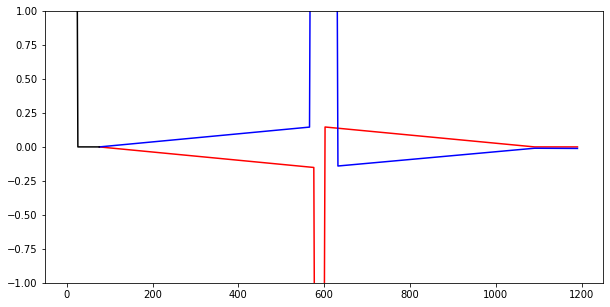

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

axes.plot(intersect_branch_1[:,2]/1e4, intersect_branch_1[:,1]/1e4,'r')
axes.plot(intersect_branch_2[:,2]/1e4, intersect_branch_2[:,1]/1e4,'b')
axes.plot(intersect_branch_0[:,2]/1e4, intersect_branch_0[:,1]/1e4,'k')

#axes.set_xlim([intersect_branch_2[-2,2]/1e4 - 0.01, intersect_branch_2[-2,2]/1e4 + 0.01])
axes.set_ylim([-1, 1])
#axes.set_aspect('equal', 'datalim')

plt.show()

In [43]:
# Set the range of the index to save
z_idx_range = 600
num1 = 550
num2 = 50
d_num = 512

# -------------------------------------------------------------
#            Get Field for Branch 2
# -------------------------------------------------------------
tic = time.time()

(result_3d_dict_2,
 result_2d_dict_2,
 check_dict_2
) = groutine.get_split_delay_single_branch_field_shear_fix(grating_pair = grating_list,
                                                           shear_fix_crystals = crystal_list_0,
                                                           channel_cuts = crystal_list_2,
                                                           total_path = total_path, 
                                                           observation = observation,
                                                           my_pulse = my_pulse,
                                                           kx_grid = kx_grid,
                                                           ky_grid = ky_grid,
                                                           kz_grid = kz_grid,
                                                           pulse_delay_time = 0.,
                                                           pulse_k0_final = np.array([0.,0.,my_pulse.klen0]),
                                                           grating_orders = [-1., 1.],
                                                           number_x = number_x,
                                                           number_y = number_y,
                                                           number_z = number_z,
                                                           z_idx_range = z_idx_range,
                                                           num1 = num1,
                                                           num2 = num2, 
                                                           d_num = 512)

toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 1.".format(toc - tic))

It takes 0.96 seconds to prepare the variables.
It takes 18.20 seconds to get the field for branch 1.


In [44]:
check_dict_2

{'intersect_points': array([[      0.        ,  162124.73685186, -999999.99992656],
        [      0.        ,  162124.55999973, -999999.99992656],
        [      0.        ,  162124.38314758, -999999.99992657],
        ...,
        [      0.        ,  162125.26740838, -999999.99992657],
        [      0.        ,  162125.09055618, -999999.99992656],
        [      0.        ,  162124.91370403, -999999.99992656]]),
 'component_final_points': array([[        0.        ,    162125.20906393, -12758080.71517171],
        [        0.        ,    162125.03221181, -12758080.77995822],
        [        0.        ,    162124.85535965, -12758080.84474475],
        ...,
        [        0.        ,    162125.73962045, -12758080.52081209],
        [        0.        ,    162125.56276826, -12758080.58559864],
        [        0.        ,    162125.3859161 , -12758080.65038517]]),
 'remaining_length': array([-11758080.71524515, -11758080.78003166, -11758080.84481819, ...,
        -11758080.52088554,

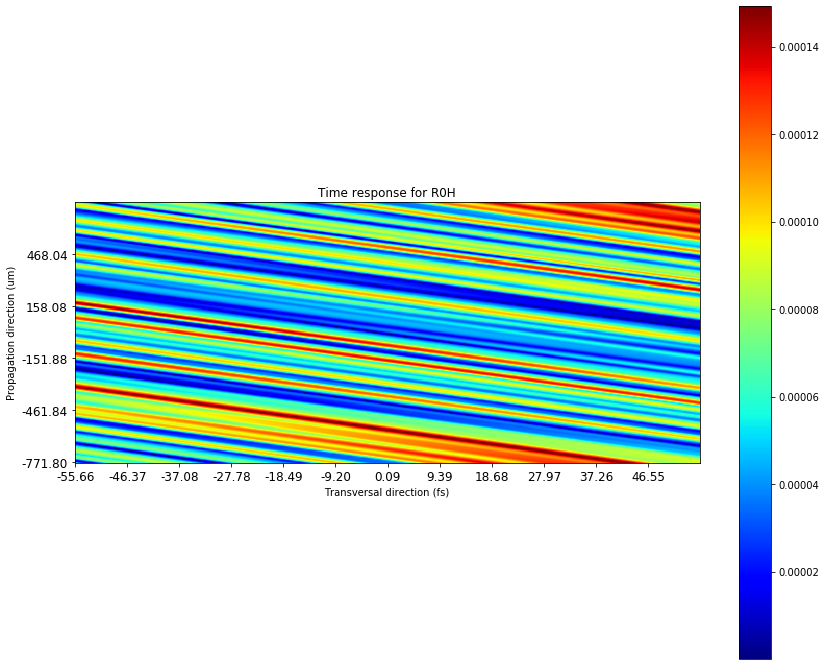

In [45]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(14)

ratio = (((axis_info['z_idx'][z_idx_range - 1] - axis_info['z_idx'][0]) /z_idx_range) /
         ((axis_info['y_idx'][-1] - axis_info['y_idx'][0]) / number_y))

field_2 = np.fft.ifftshift(np.fft.ifft(result_2d_dict_2['y_field_2d'], axis=0), axes=0)

im = axes.imshow(np.abs( field_2 ),
                 #vmin=  17,
                 #vmax = 25.,
                 cmap='jet', 
                 origin='lower',
                 #aspect = 1/util.c,
                 )

axes.set_title("Time response for R0H")
axes.set_yticks(np.arange(0, number_y, step=50))
axes.set_yticklabels(axis_info["y_idx_tick"][::50], fontsize=12)
axes.set_xticks(np.arange(0, z_idx_range, step=50))
axes.set_xticklabels(axis_info["z_idx_tick"][number_z//2 - z_idx_range//2:
                                              number_z//2 + z_idx_range//2:50], fontsize=12)

axes.set_ylabel("Propagation direction (um)")
axes.set_xlabel("Transversal direction (fs)")
fig.colorbar(im, ax=axes)
# Show the canvas

plt.show()